# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega_{surf} + R_{diff,R2} \end{equation*}
## **SODA 3.4.2**

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [2]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.4ab3d64ca9a540c497d0c2856e8824a9 Dashboard: /services/dask-gateway/clusters/staging.4ab3d64ca9a540c497d0c2856e8824a9/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [157]:
client.close()
cluster.close()

In [3]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
import xmitgcm
import xgcm
from xhistogram.xarray import histogram
from fastjmd95 import jmd95numba
import fastjmd95
xr.set_options(display_style='text');

In [4]:
url_ocean = 'gs://pangeo-forge-us-central1/pangeo-forge/soda/soda3.4.2_5dy_ocean_or'
fs = gcsfs.GCSFileSystem()
ocean = xr.open_zarr(fs.get_mapper(url_ocean), consolidated=True, decode_times=False)

In [5]:
#fix time dim (1898/1897 indices are 1980-01-01)
test_time = xr.cftime_range('1993-01-04 13:00:00', freq='5D', periods=1970, calendar='julian')
ocean_test = ocean.copy()
ocean_test = ocean.assign_coords(coords={'time': test_time})
#ocean_test = ocean.assign_attrs(ocean.time.attrs)
ocean['time'] = ocean_test.time

In [6]:
path = 'pangeo-tmp/stb2145/SODA/datasets/'

transport = xr.open_zarr(gcsfs.GCSMap(path + 'transport_wg.zarr'))
cells = xr.open_zarr(gcsfs.GCSMap(path + 'cells_wg.zarr'))
surf = xr.open_zarr(gcsfs.GCSMap(path + 'surf_terms.zarr'))
totend = xr.open_zarr(gcsfs.GCSMap(path + 'totend.zarr'))

## <font color='Green'>Slice to WG region</font>

In [7]:
#WG boundaries (80˚S, 62˚S, 65˚W, 30˚E)
lower_lat = 0 #-80.02101494
upper_lat = 169 #-62.01972704
left_lon =  859 #-65.12
right_lon = 1240 #30.12

lower_lat_u = 0 #-79.96821565
upper_lat_u = 169 #-61.96096874 python is right exclusive so will have -62.0 in array
left_lon_u = 859 #-65.0
right_lon_u = 1240 #30.25 python is right exclusive so will have 30.0˚E

In [8]:
#set the boundaries
lat_range = dict(yt_ocean=slice(lower_lat, upper_lat), yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range = dict(xt_ocean=slice(left_lon, right_lon), xu_ocean=slice(left_lon_u, right_lon_u))

lat_range_no_u = dict(yt_ocean=slice(lower_lat, upper_lat))
lon_range_no_u = dict(xt_ocean=slice(left_lon, right_lon))

lat_range_u = dict(yu_ocean=slice(lower_lat_u, upper_lat_u))
lon_range_u = dict(xu_ocean=slice(left_lon_u, right_lon_u))

In [9]:
ds_wg = ocean.isel(**lat_range, **lon_range)
#ds_wg = ds.isel(**lat_range, **lon_range)

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [10]:
pref = 2000

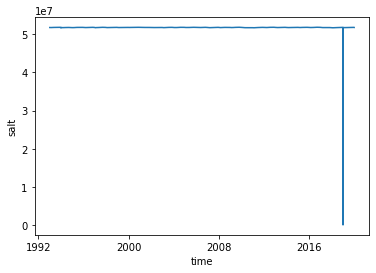

In [14]:
ds_wg.salt.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()

In [11]:
mask = ds_wg.time != ds_wg.time.sel(time='2018-12-24').values
salt_mask = ds_wg.salt.where(mask)#.load()
temp_mask = ds_wg.temp.where(mask)#.load()

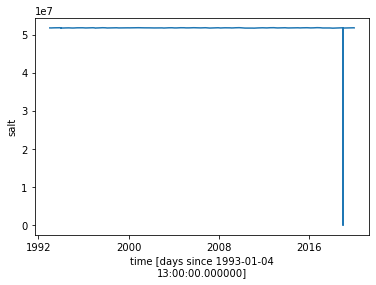

In [57]:
salt_mask.sum(('st_ocean', 'yt_ocean', 'xt_ocean')).plot()
#still shows dip bc of .sum() but mask does work!

In [12]:
#USE THIS!!
sigma2 = fastjmd95.rho(salt_mask, temp_mask, pref)

In [13]:
sigma2

<xarray.DataArray (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<transpose, shape=(1970, 50, 169, 381), dtype=float64, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

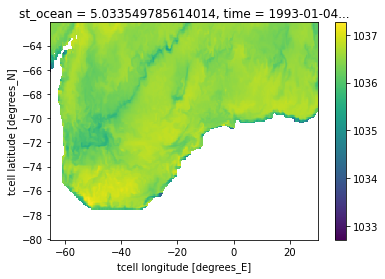

In [31]:
sigma2[0,0].plot()

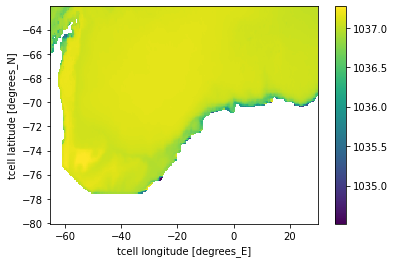

In [32]:
sigma2.mean(dim=['time', 'st_ocean']).plot()

In [25]:
sigma2.nbytes/1e9

50.738532

In [ ]:
sigma2.mean(dim=['time', 'st_ocean']).plot.hist()

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

In [14]:
drhodt = fastjmd95.drhodt(salt_mask, temp_mask, pref)
drhods = fastjmd95.drhods(salt_mask, temp_mask, pref)

In [15]:
vol = cells.dx_interp * cells.dy_u * cells.dz

In [16]:
totttend_truth = (totend.totttend * drhodt[1:])# * vol)#.load()

In [17]:
totstend_truth = (totend.totstend * drhods[1:])# * vol)#.load()

In [18]:
dt_values = (surf.time.diff('time') / 1e9).astype('f4')
dt = xr.DataArray(dt_values, dims=['time'], 
                  coords={'time': (['time'], surf.time.values[1:])}) #shaves off first time stamp in `surf.time`
surf.coords['dt'] = dt

In [17]:
surf.dt[1:]

<xarray.DataArray 'dt' (time: 1969)>
array([432000., 432000., 432000., ..., 432000., 432000., 432000.],
      dtype=float32)
Coordinates:
  * time     (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
    dt       (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

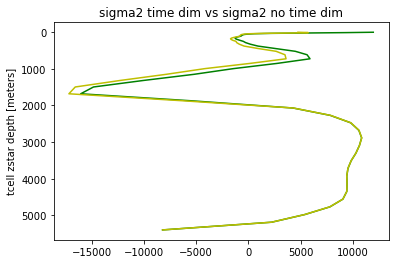

In [22]:
(sigma2.diff(dim='time')*vol/surf.dt[1:]).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='green')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim');

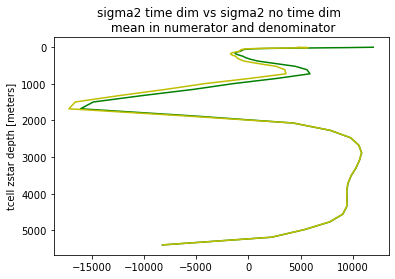

In [67]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, 
                                                                                                               color='green')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
plt.title('sigma2 time dim vs sigma2 no time dim \n mean in numerator and denominator');

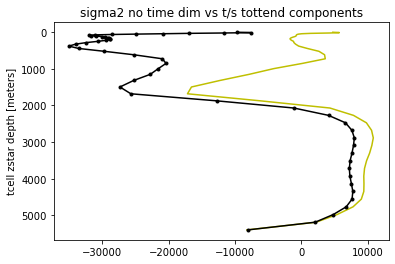

In [140]:
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='y')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='k', marker='.')
plt.title('sigma2 no time dim vs t/s tottend components');

In [ ]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', 
                                                                                                               yincrease=False, color='y')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='k', marker='.')
plt.title('sigma2 time dim vs t/s tottend components');

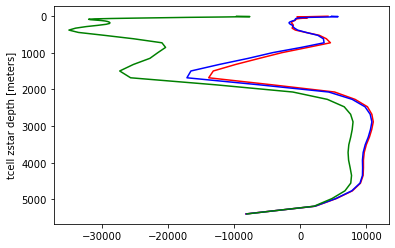

In [24]:
((sigma2.diff(dim='time')*vol).mean(dim='time')/surf.dt[1:].mean(dim='time')).sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', 
                                                                                                               yincrease=False, color='red')
totend_truth.sum(dim=['yt_ocean', 'xt_ocean']).plot(y='st_ocean', yincrease=False, color='blue')
(totttend_truth + totstend_truth).sum(dim=['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False, color='green');

In [19]:
totend_truth = ((sigma2.diff(dim='time') * vol) / surf.dt[1:]).drop('dt')#.load()

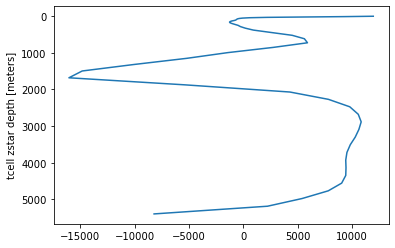

In [88]:
totend_truth.sum(['yt_ocean', 'xt_ocean']).mean(dim='time').plot(y='st_ocean', yincrease=False)

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

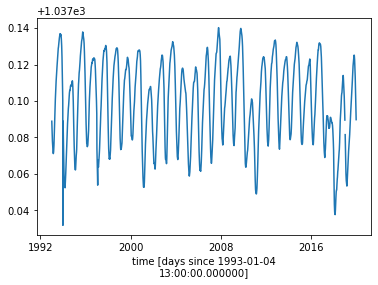

In [101]:
sigma2.mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

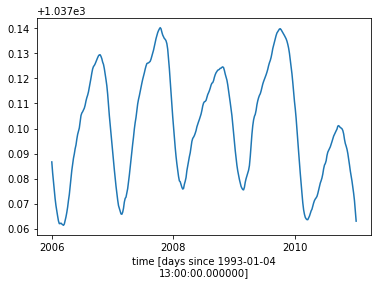

In [105]:
#SOSE time period
#density avged over volume gets denser in middle of the year (AA winter) and lighter around spring/summer
sigma2.sel(time=slice('2006', '2010')).mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

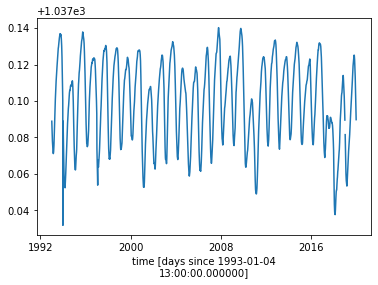

In [106]:
sigma2.sel(time=slice('1980', '2019')).mean(dim=['xt_ocean', 'yt_ocean', 'st_ocean']).plot()

In [107]:
sigma2.min().values

array(1032.01930673)

In [108]:
sigma2.max().values

array(1039.03267855)

In [20]:
# define bins (ECCO & SOSE bin size 1000)
delta_sigma = 0.01
sigma_bins = np.arange(1032.0, 1039.0, delta_sigma)

In [21]:
sigma_bins.size

700

In [23]:
sigma_dist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=vol.fillna(0.), dim=['xt_ocean', 'yt_ocean', 'st_ocean']).load()

In [24]:
sigma_dist

<xarray.DataArray 'histogram_sigma2' (time: 1970, sigma2_bin: 699)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

(1037.0, 1037.3)

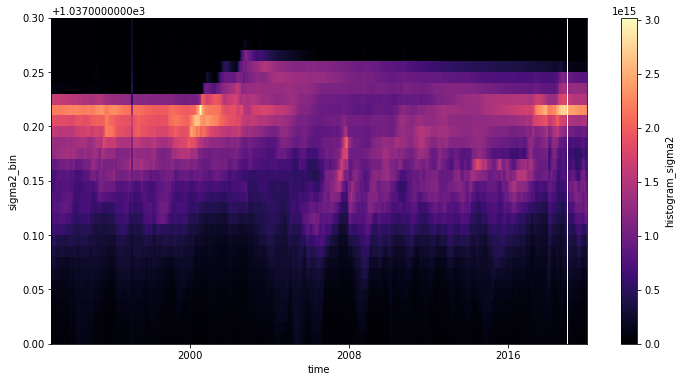

In [25]:
sigma_dist.where(mask).plot(x='time', figsize=(12, 6), cmap='magma')
plt.ylim(1037, 1037.3)

(1037.0, 1037.3)

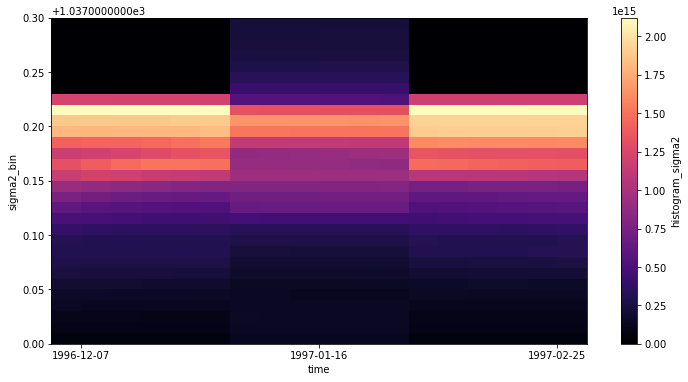

In [27]:
sigma_dist.sel(time=slice('1996-12', '1997-02')).where(mask).plot(x='time', figsize=(12, 6), cmap='magma')
plt.ylim(1037, 1037.3)

(1037.0, 1037.3)

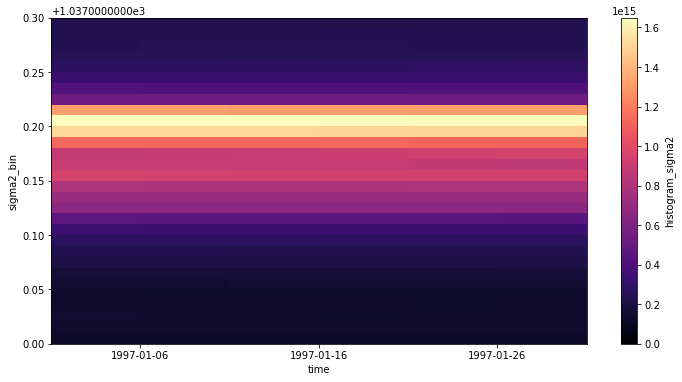

In [43]:
sigma_dist.sel(time=slice('1997-01-03', '1997-01-28')).where(mask).plot(x='time', figsize=(12, 6), cmap='magma')
plt.ylim(1037, 1037.3)

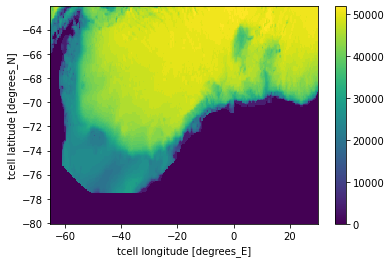

In [47]:
sigma2.sel(time=slice('1997-01-03', '1997-01-28')).sum('st_ocean').mean(dim='time').plot()

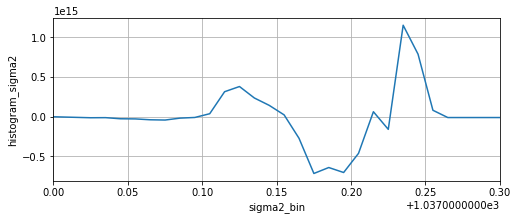

In [56]:
plt.figure(figsize=(8,3))
(sigma_dist[-1] - sigma_dist[0]).plot()
plt.xlim(1037, 1037.3)
plt.grid();

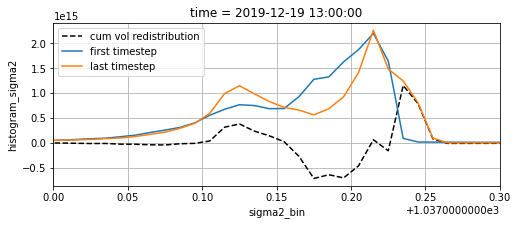

In [70]:
plt.figure(figsize=(8,3))
(sigma_dist[-1] - sigma_dist[0]).plot(color='k', label='cum vol redistribution', linestyle='dashed')
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037, 1037.3)
plt.grid();

- 1037.0-1037.08: volume is lost (2nd plot), negative lobe meaning volume is decreasing (1st plot, black dash), 

- 1037.10-1037.16: volume is added (2nd plot), positive lobe meaning volume is increasing (1st plot, black dash), negative slope for majority of this interval, meaning the rate of volume redistribution is decreasing so therefore, more water buildup of waters in this range bc of less distribution of the waters (that’s why you see more volume in “last timestep” and positive lobe in 1st plot). 

- 1037.16-1037.22: volume is lost (2nd plot), negative lobe meaning volume is decreasing (1st plot, black dash), first half of this interval is negative slope (1st plot) but since it's a negative lobe this negative slope means the vol redistribution is increasing (that's why there's a larger gap in first half of this interval (2nd plot) than the second half which is associated with a positive slope (still in negative lobe) so that means decrease in redistribution rate of cum vol.

- 1037.22-1037.26: volume is added (2nd plot), positive lobe meaning volume is increasing (1st plot, black dash), mostly negative slope meaning decreased rate of volume redistribution meaning waters in this range are being distributed at a slower rate (that’s why you see more volume in “last timestep” and positive lobe in 1st plot).

(1037.5, 1036.4)

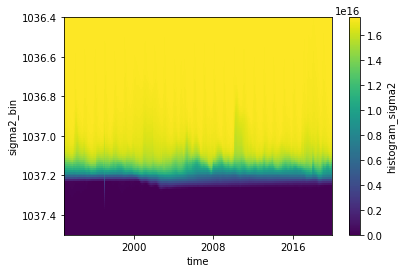

In [71]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.where(mask).transpose().plot()
plt.ylim(1037.5, 1036.4)

In [72]:
V

<xarray.DataArray 'histogram_sigma2' (time: 1970, sigma2_bin: 699)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74516139e+16, 1.74516139e+16, 1.74516139e+16]])
Coordinates:
  * time        (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

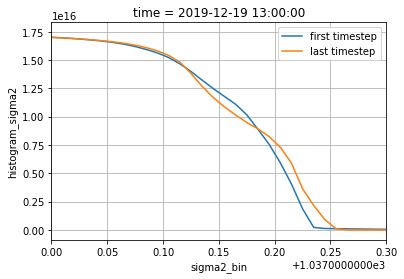

In [75]:
#waters up to 1037.18 lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037, 1037.3)
plt.grid();

In [76]:
delta_V = V.diff(dim='time')

In [77]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time: 1969, sigma2_bin: 699)>
array([[  0.,   0.,   0., ...,   8.,   8.,   8.],
       [  0.,   0.,   0., ..., -18., -18., -18.],
       [  0.,   0.,   0., ...,  22.,  22.,  22.],
       ...,
       [  0.,   0.,   0., ...,  -8.,  -8.,  -8.],
       [  0.,   0.,   0., ...,  16.,  16.,  16.],
       [  0.,   0.,   0., ...,   4.,   4.,   4.]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

In [78]:
surf.dt[1:]

<xarray.DataArray 'dt' (time: 1969)>
array([432000., 432000., 432000., ..., 432000., 432000., 432000.],
      dtype=float32)
Coordinates:
  * time     (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
    dt       (time) float32 4.32e+05 4.32e+05 4.32e+05 ... 4.32e+05 4.32e+05

## $\frac{\partial \mathcal{V}}{\partial t}$

In [79]:
dVdt = (delta_V / surf.dt[1:]).drop('dt')

In [80]:
dVdt

<xarray.DataArray (time: 1969, sigma2_bin: 699)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.85185185e-05,  1.85185185e-05,  1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.16666667e-05, -4.16666667e-05, -4.16666667e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.09259259e-05,  5.09259259e-05,  5.09259259e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.85185185e-05, -1.85185185e-05, -1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.70370370e-05,  3.70370370e-05,  3.70370370e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.25925926e-06,  9.25925926e-06,  9.25925926e-06]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

(1036.0, 1037.3)

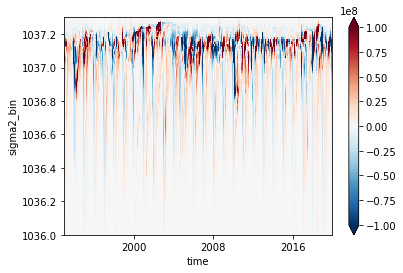

In [81]:
dVdt.where(mask).plot(x='time', vmax=1e8)
plt.ylim(1036, 1037.3)

(1036.0, 1037.3)

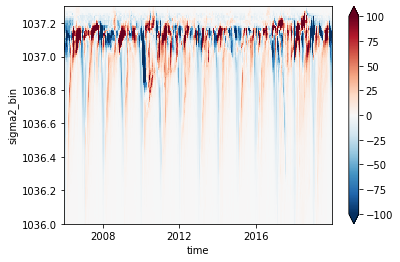

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1125)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/p

In [163]:
#SOSE time period
(dVdt.where(mask)/1e6).sel(time=slice('2006', '2019')).plot(x='time', vmax=1e2)
plt.ylim(1036, 1037.3)

## $\Omega_{total}$

In [83]:
omega_total = - histogram(sigma2[1:].rename('sigma2'), bins=[sigma_bins],
                          weights=totend_truth.fillna(0.),
                          dim=['yt_ocean', 'xt_ocean', 'st_ocean']) / (- delta_sigma)

In [85]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-staging-dask-gateway.staging:80/staging.4ab3d64ca9a540c497d0c2856e8824a9 Dashboard: /services/dask-gateway/clusters/staging.4ab3d64ca9a540c497d0c2856e8824a9/status,Cluster Workers: 30 Cores: 60 Memory: 240.00 GiB


In [86]:
omega_total.load()

<xarray.DataArray 'histogram_sigma2' (time: 1969, sigma2_bin: 699)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03

In [87]:
dVdt

<xarray.DataArray (time: 1969, sigma2_bin: 699)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.85185185e-05,  1.85185185e-05,  1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.16666667e-05, -4.16666667e-05, -4.16666667e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.09259259e-05,  5.09259259e-05,  5.09259259e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.85185185e-05, -1.85185185e-05, -1.85185185e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.70370370e-05,  3.70370370e-05,  3.70370370e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.25925926e-06,  9.25925926e-06,  9.25925926e-06]])
Coordinates:
  * time        (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

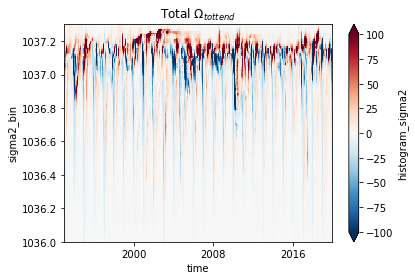

In [88]:
(omega_total/1e6).plot(x='time', vmax=1e2)
plt.ylim(ymin=1036, ymax=1037.3)
plt.title(r'Total $\Omega_{tottend}$');

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of sigma layers) </font>

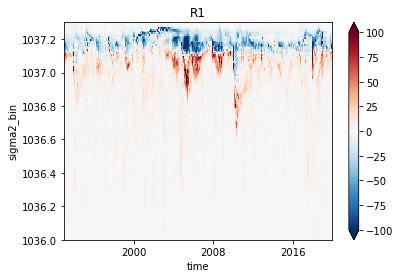

In [89]:
R1 = dVdt - omega_total

(R1/1e6).where(mask).plot(x='time', vmax=1e2)
plt.ylim(ymin=1036, ymax=1037.3)
plt.title('R1');

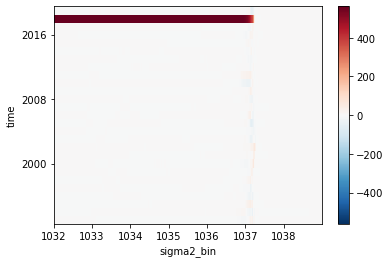

In [90]:
(dVdt/1e6).where(mask).resample(time='AS').mean(dim='time').plot()

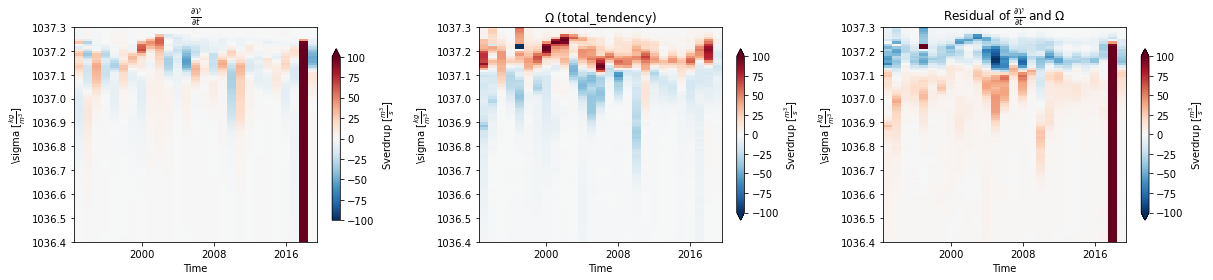

In [91]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(17, 4), sharex=True)

(dVdt/1e6).where(mask).resample(time='AS').mean(dim='time').plot(x='time', ax=ax0, vmax=100,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')#, fontsize=14)
ax0.set_xlabel('Time')#, fontsize=14)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$')#, fontsize=24)
ax0.set_ylim(1036.4, 1037.3)

(omega_total/1e6).where(mask).resample(time='AS').mean(dim='time').plot(x='time', ax=ax1, vmax=100,
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_xlabel('Time')#, fontsize=14)
ax1.set_title('$\Omega$ (total_tendency)')
ax1.set_ylim(1036.4, 1037.3)

(R1/1e6).where(mask).resample(time='AS').mean(dim='time').plot(x='time', ax=ax2, vmax=100,
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_xlabel('Time')
ax2.set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$')
ax2.set_ylim(1036.4, 1037.3)

plt.tight_layout();

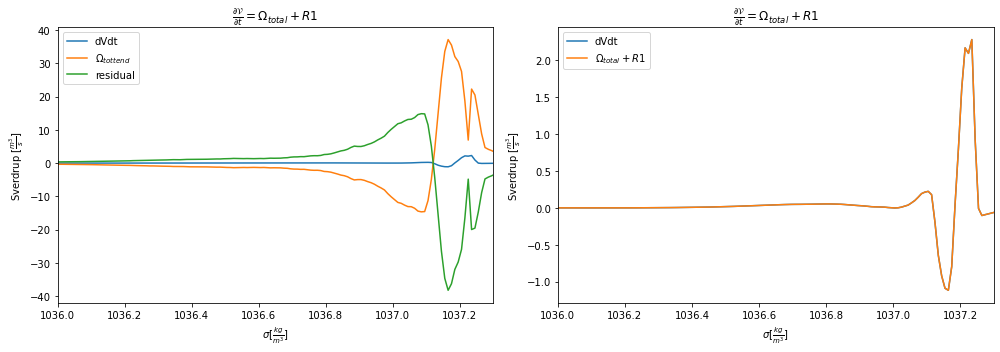

In [92]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax0)
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=ax0)
(R1/1e6).mean(dim='time').plot(label='residual', ax=ax0)
ax0.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax0.set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
ax0.legend()
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
ax0.set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=ax1)
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=ax1)
ax1.set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
ax1.set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
ax1.legend()
ax1.set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
ax1.set_xlim(1036, 1037.3)

plt.tight_layout();

## <font color='Green'>\begin{equation*} \Psi_{vel} = \vec{\textbf{u}} \cdot \nabla \sigma_2 \end{equation*}</font>

In [96]:
grid_transport = xgcm.Grid(transport, coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'}, 
                                              'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                                              'T': {'center': 'time'},
                                              'Z': {'center': 'st_edges_ocean', 'right': 'st_ocean'},
                                              'Zu': {'center': 'sw_edges_ocean', 'right': 'sw_ocean'}},
                     periodic=['X'])
grid_transport

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
T Axis (not periodic, boundary=None):
  * center   time
Z Axis (not periodic, boundary=None):
  * center   st_edges_ocean --> right
  * right    st_ocean --> center
Zu Axis (not periodic, boundary=None):
  * center   sw_edges_ocean --> right
  * right    sw_ocean --> center

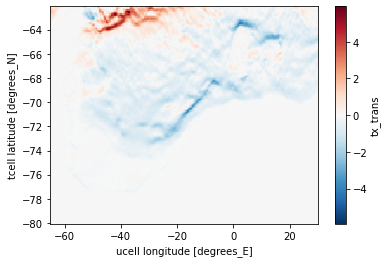

In [97]:
transport.tx_trans.sum(dim='st_ocean').mean(dim='time').plot()

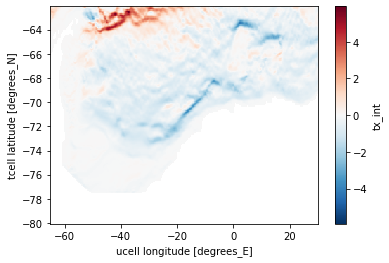

In [98]:
transport.tx_int.mean(dim='time').plot()

In [99]:
u_transport_right = (transport.tx_trans).isel(xu_ocean=-1)#.load()
u_transport_left = (transport.tx_trans).isel(xu_ocean=0)#.load()

v_transport = (transport.ty_trans).isel(yu_ocean=-1)#.load()

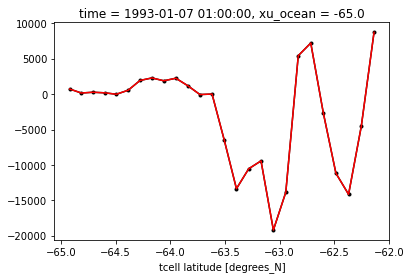

In [202]:
u_transport_left[0].sel(yt_ocean=slice(-65,-62)).plot(color='k', marker='.')
u_transport_left_int[0].sel(yt_ocean=slice(-65,-62)).plot(color='red')

In [113]:
# BEST WAY TO DO IT
u_transport_mean_value = (u_transport_right.fillna(0.).sum(dim=['yt_ocean', 'st_ocean']) -
                          u_transport_left.fillna(0.).sum(dim=['yt_ocean', 'st_ocean'])).mean(dim='time')
u_transport_mean_value.load()

<xarray.DataArray 'tx_trans' ()>
array(-38.79175, dtype=float32)

In [114]:
v_transport_mean_value = (v_transport).fillna(0.).sum(dim=['xt_ocean', 'st_ocean']).mean(dim='time')
v_transport_mean_value.load()

<xarray.DataArray 'ty_trans' ()>
array(38.92792, dtype=float32)
Coordinates:
    yu_ocean  float64 -62.08

In [115]:
residual = u_transport_mean_value + v_transport_mean_value #+ surf_transport_mean_value
float(residual)

0.13616943359375

In [101]:
def interp_right_with_land(array, wet_mask):
    # there are several different ways to implement this; this is one
    
    data = wet_mask * np.nan_to_num(array)  # zeros the data on land
    data_shift = np.roll(data, 1, -1)
    
    wet_fac = wet_mask + np.roll(wet_mask, 1, -1)
    # wet_fac = 0: water on left AND right
    # wet_fac = 1: water on left OR right
    # wet_fac = 2: no land nearby
    
    # division by zero creates NaNs
    out =  1 / wet_fac * (data + data_shift)
    
    return np.nan_to_num(out)

In [102]:
wet_mask_full = sigma2.notnull().astype(np.int8)
wet_mask_full

<xarray.DataArray (time: 1970, st_ocean: 50, yt_ocean: 169, xt_ocean: 381)>
dask.array<astype, shape=(1970, 50, 169, 381), dtype=int8, chunksize=(1, 50, 169, 381), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
  * time      (time) object 1993-01-04 13:00:00 ... 2019-12-19 13:00:00
  * xt_ocean  (xt_ocean) float64 -65.12 -64.88 -64.62 ... 29.38 29.62 29.88
  * yt_ocean  (yt_ocean) float64 -80.02 -79.92 -79.81 ... -62.37 -62.25 -62.14

In [103]:
sigma_at_tx_full = xr.apply_ufunc(
    interp_right_with_land,
    sigma2,
    wet_mask_full,
    dask='parallelized',
    input_core_dims=[['yt_ocean', 'xt_ocean'], ['yt_ocean', 'xt_ocean']],
    output_core_dims=[['yt_ocean', 'xu_ocean']],
    dask_gufunc_kwargs=dict(output_sizes={'xu_ocean': transport.dims['xu_ocean']}),
    output_dtypes=[sigma2.dtype],
).assign_coords(xu_ocean=transport.xu_ocean)

sigma_at_ty_full = xr.apply_ufunc(
    interp_right_with_land,
    sigma2,
    wet_mask_full,
    dask='parallelized',
    input_core_dims=[['yt_ocean', 'xt_ocean'], ['yt_ocean', 'xt_ocean']],
    output_core_dims=[['yu_ocean', 'xt_ocean']],
    dask_gufunc_kwargs=dict(output_sizes={'yu_ocean': transport.dims['yu_ocean']}),
    output_dtypes=[sigma2.dtype],
).assign_coords(yu_ocean=transport.yu_ocean)


In [104]:
sigma_at_tx_full.equals(sigma_at_tx_full.where(sigma_at_tx_full.notnull()))

True

In [105]:
sigma_at_ty_full.equals(sigma_at_ty_full.where(sigma_at_ty_full.notnull()))

True

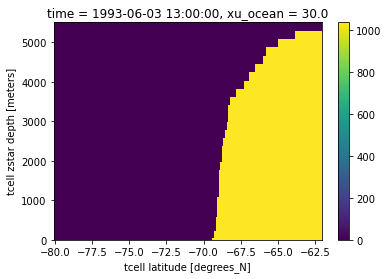

In [84]:
sigma_at_tx_full.isel(xu_ocean=-1)[30].plot()

In [106]:
#interp sigma time dim onto transport time dim
sigma2_u_right_time_interp = sigma_at_tx_full.isel(xu_ocean=-1).interp(time=transport.time)
sigma2_u_left_time_interp = sigma_at_tx_full.isel(xu_ocean=0).interp(time=transport.time)
sigma2_v_time_interp = sigma_at_ty_full.isel(yu_ocean=-1).interp(time=transport.time)

In [112]:
u_transport_right.sum(dim=('yt_ocean', 'st_ocean'))[0].values

array(-9.028181, dtype=float32)

In [107]:
#this is the delta function part of the equation above
u_binned_right = histogram(sigma2_u_right_time_interp.rename('sigma2'), bins=[sigma_bins],
                           weights=u_transport_right.fillna(0.), dim=['st_ocean','yt_ocean']).load()
u_binned_left = histogram(sigma2_u_left_time_interp.rename('sigma2'), bins=[sigma_bins],
                          weights=u_transport_left.fillna(0.), dim=['st_ocean','yt_ocean']).load()
v_binned = histogram(sigma2_v_time_interp.rename('sigma2'), bins=[sigma_bins],
                     weights=v_transport.fillna(0.), dim=['st_ocean','xt_ocean']).load()

In [108]:
u_binned_right.sum(dim=('sigma2_bin'))[0].compute()

<xarray.DataArray 'histogram_sigma2' ()>
array(-9.02818043)
Coordinates:
    time     object 1993-01-07 01:00:00

In [117]:
float((-u_binned_left + u_binned_right + v_binned).sum('sigma2_bin').mean(dim='time'))

0.13837522833578175

In [118]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (u_binned_right 
             - u_binned_left 
             + v_binned).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 985, sigma2_bin: 699)>
array([[-0.        , -0.        , -0.        , ..., -1.3514323 ,
        -1.3514323 , -1.3514323 ],
       [-0.        , -0.        , -0.        , ..., -0.41340604,
        -0.41340604, -0.41340604],
       [-0.        , -0.        , -0.        , ..., -1.26238197,
        -1.26238197, -1.26238197],
       ...,
       [-0.        , -0.        , -0.        , ...,  0.25241277,
         0.25241277,  0.25241277],
       [-0.        , -0.        , -0.        , ...,  0.11213115,
         0.11213115,  0.11213115],
       [-0.        , -0.        , -0.        , ..., -0.38434065,
        -0.38434065, -0.38434065]])
Coordinates:
  * time        (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03

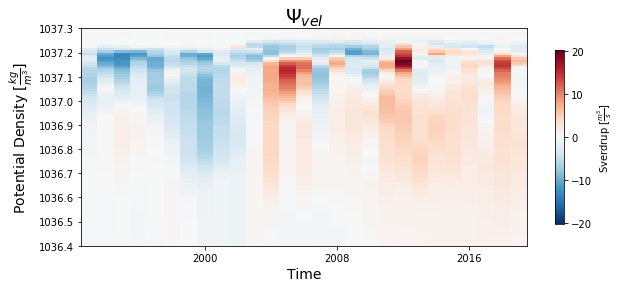

In [119]:
psi_vel.resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4),
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
plt.ylim(1036.4, 1037.3);

(1036.5, 1037.5)

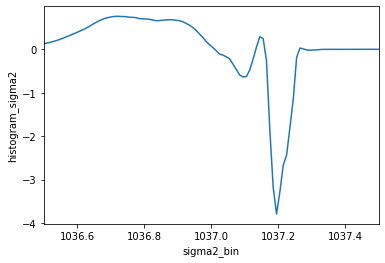

In [120]:
psi_vel.mean(dim='time').plot()
plt.xlim(1036.5, 1037.5)

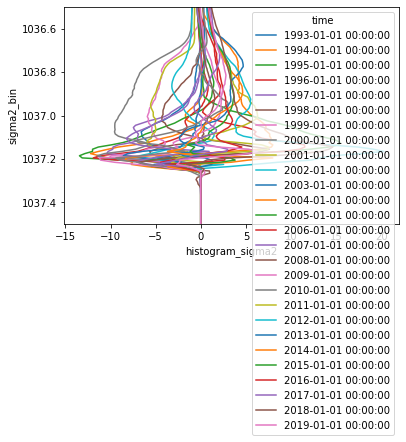

In [121]:
psi_vel.resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin');#, add_legend=True)
plt.ylim(1037.5, 1036.5);

# <font color='Green'>\begin{equation*} \Omega_{trans} = \frac{\partial V}{\partial t} - \Psi_{vel}\end{equation*} </font>

In [166]:
#omega_tot_interp = omega_total.interp(time=psi_vel.time)
#R1_interp = R1.interp(time=psi_vel.time)
dVdt_interp = dVdt.interp(time=psi_vel.time)

In [173]:
omega_trans = (dVdt_interp/1e6) - psi_vel

In [174]:
omega_trans.load()

<xarray.DataArray (time: 985, sigma2_bin: 699)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,  0.41340604,
         0.41340604,  0.41340604],
       [ 0.        ,  0.        ,  0.        , ...,  1.26238197,
         1.26238197,  1.26238197],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.25241277,
        -0.25241277, -0.25241277],
       [ 0.        ,  0.        ,  0.        , ..., -0.11213115,
        -0.11213115, -0.11213115],
       [ 0.        ,  0.        ,  0.        , ...,  0.38434065,
         0.38434065,  0.38434065]])
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.039e+03 1.039e+03 ... 1.032e+03 1.032e+03
  * time        (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} = \Psi_{vel} + \Omega_{trans} \end{equation*} </font>

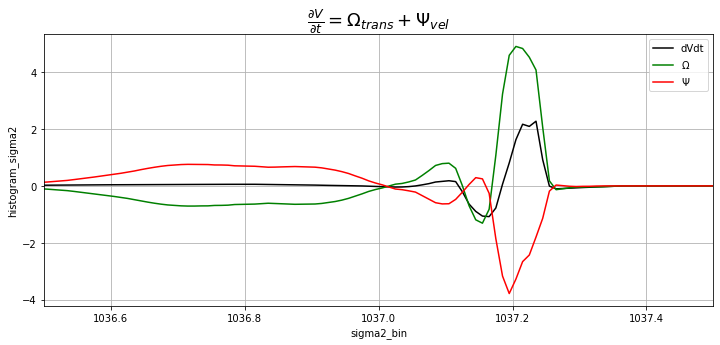

In [179]:
plt.figure(figsize=(12,5))
#(omega_tot_interp/1e6).mean(dim='time').plot(label='tottend', color='k')
(dVdt_interp/1e6).mean(dim='time').plot(label='dVdt', color='k')
omega_trans.mean(dim='time').plot(label=r'$\Omega$', color='green')
#R2.mean(dim='time').plot(label='R2', color='lightgreen')
psi_vel.mean(dim='time').plot(label=r'$\Psi$', color='red')
#(R1_interp/1e6).mean(dim='time').plot(label='R1', color='blue', linestyle='dashed')
plt.grid()
plt.legend()
plt.xlim(1036.5, 1037.5)
plt.title(r'$\frac{\partial V}{\partial t} = \Omega_{trans} + \Psi_{vel}$', fontsize=18);

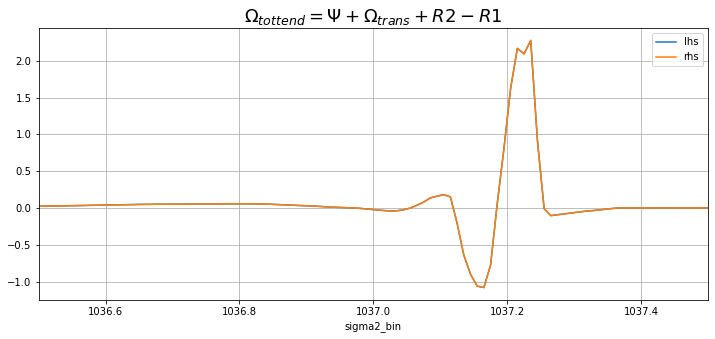

In [177]:
plt.figure(figsize=(12,5))
(dVdt_interp/1e6).mean(dim='time').plot(label='lhs')
(omega_trans + psi_vel).mean(dim='time').plot(label='rhs')
plt.grid()
plt.legend()
plt.xlim(1036.5, 1037.5)
plt.title(r'$\Omega_{tottend} = \Psi + \Omega_{trans} + R2 - R1$', fontsize=18, fontweight='bold');

## Saving Data

In [175]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [166]:
dVdt_resample = dVdt.resample(time='10D').mean().interp(time=psi_vel.time)

In [162]:
transport = xr.merge([u_binned_right.rename('u_binned_right'), 
                      u_binned_left.rename('u_binned_left'), 
                      v_binned.rename('v_binned'), psi_vel.rename('psi_vel')])

In [182]:
wmt_budget_terms_resampled = xr.merge([dVdt_resample.rename('dVdt'), omega_resample,
                                       transport, R2.rename('R2')])

In [181]:
#can't add transport vel terms bc their orginal timestamp is 10D
wmt_budget_terms = xr.merge([dVdt.rename('dVdt'), omegas, R1.rename('R1')])

In [183]:
wmt_budget_terms

<xarray.Dataset>
Dimensions:         (sigma2_bin: 699, time: 1969)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) object 1993-01-09 13:00:00 ... 2019-12-19 13:00:00
Data variables:
    dVdt            (time, sigma2_bin) float64 1.852e-05 1.852e-05 ... 0.0 0.0
    omega_total     (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf      (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_SLT  (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_TH   (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_sw_TH     (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    R1              (time, sigma2_bin) float64 1.852e-05 1.852e-05 ... 0.0 0.0

In [184]:
wmt_budget_terms_resampled

<xarray.Dataset>
Dimensions:         (sigma2_bin: 699, time: 985)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) object 1993-01-04 00:00:00 ... 2019-12-14 00:00:00
Data variables:
    dVdt            (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    omega_total     (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    omega_surf      (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    omega_surf_SLT  (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    omega_surf_TH   (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    omega_sw_TH     (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0
    u_binned_right  (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u_binned_left   (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    v_binned        (time, sigma2_bin) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_vel         (time, sigma2_bin) float64 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0
    R2              (time, sigma2_bin) float64 nan nan nan nan ... 0.0 0.0 0.0

In [185]:
#uploading wmt budget terms
gcsmap_wmt_budget_terms = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/wmt_budget_terms/wmt_budget_terms.zarr')
wmt_budget_terms.to_zarr(gcsmap_wmt_budget_terms, mode='w')

In [186]:
#uploading wmt budget terms
gcsmap_wmt_budget_terms_resample = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/wmt_budget_terms/wmt_budget_terms_resample.zarr')
wmt_budget_terms_resampled.to_zarr(gcsmap_wmt_budget_terms_resample, mode='w')